# Information plane experiments (DNN classifier, MNIST)

## Preamble

In [1]:
import numpy as np

In [2]:
import torch
import torchvision

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 1


In [4]:
import os
from pathlib import Path

path = Path("../../data/").resolve()
experiments_path = path / "mutual_information/MNIST/"
models_path = experiments_path / "models/"
results_path = experiments_path / "results_smi/"

Slicing Compressor

In [5]:
from joblib import Parallel, delayed

def sample_spherical(dim, n_projections):
    sampled_vectors = np.array([]).reshape(0, dim)
    while len(sampled_vectors) < n_projections:
        vec = np.random.multivariate_normal(np.zeros(dim), np.identity(dim), size=dim) # (num_vec, dim)
        vec = np.linalg.qr(vec).Q
        sampled_vectors = np.vstack((sampled_vectors, vec))
    return sampled_vectors[:n_projections] # (num_vec, dim)

class smi_compressor():
    def __init__(self, dim, n_projections):
        self.theta = sample_spherical(dim=dim, n_projections=n_projections) # (n_projections, dim)
        
    def __call__(self, X):
        # getting projections
        X_compressed = np.dot(self.theta, X.T)
        return X_compressed # m x n
    
def measure_smi_projection(mi_estimator, x, y):
    mi_estimator.fit(x, y, verbose=0)
    return mi_estimator.estimate(x, y, verbose=0)

### Global settings

In [6]:
# Autoencoder for inputs.
X_latent_dim = 4             # Input dimension after compression.
X_autoencoder_n_epochs = 200 # Number of epochs to train the autoencoder.
load_X_autoencoder = True    # Reload weights of the autoencoder.

# Autoencoder for layers.
L_latent_dim = 4              # Layer dimension after compression.
L_autoencoder_n_epochs = 100  # Number of epochs to train the autoencoder.

# Classifier.
classifier_lr = 1e-5      # Classifier learning rate.
classifier_n_epochs = 300 # Number of epochs to train the classifier. # 300
sigma = 1e-3              # Noise-to-signal ratio.

## Dataset

In [7]:
from torchvision.datasets import MNIST

In [8]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [10]:
batch_size_train = 1024
batch_size_test  = 2048

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
eval_dataloader  = test_dataloader #torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)

### Visualisation

In [12]:
from misc.utils import *

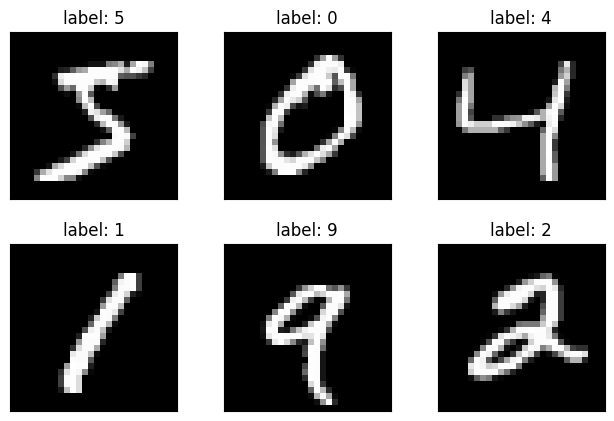

In [13]:
show_images(*split_lists([(train_dataset[index][0], f"label: {train_dataset[index][1]}") for index in range(6)]))

## Compressing the inputs

In [14]:
from mutinfo.torch.datasets import AutoencoderDataset

In [15]:
train_dataset_autoencoder = AutoencoderDataset(train_dataset)
test_dataset_autoencoder = AutoencoderDataset(test_dataset)

In [16]:
autoencoder_batch_size_train = 2048
autoencoder_batch_size_test  = autoencoder_batch_size_train * 2

In [17]:
train_dataloader_autoencoder = torch.utils.data.DataLoader(train_dataset_autoencoder, batch_size=autoencoder_batch_size_train, shuffle=True)
test_dataloader_autoencoder  = torch.utils.data.DataLoader(test_dataset_autoencoder, batch_size=autoencoder_batch_size_test, shuffle=False)

In [18]:
from misc.autoencoder import *

In [19]:
import random
from IPython.display import clear_output

def autoencoder_callback(autoencoder, autoencoder_metrics=None):
    clear_output(True)
    
    was_in_training = autoencoder.training
    autoencoder.eval()
    
    # Display some images..
    with torch.no_grad():
        samples = [sample[0] for sample in random.choices(test_dataset_autoencoder, k=3)]
        samples += [autoencoder(sample[None,:].to(device)).cpu().detach()[0] for sample in samples]
        show_images(samples)
        
    # Display loss/metrics plots.
    if not (autoencoder_metrics is None):
        plt.figure(figsize=(12,4))
        for index, (name, history) in enumerate(sorted(autoencoder_metrics.items())):
            plt.subplot(1, len(autoencoder_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();
        
    autoencoder.train(was_in_training)

Using Autoencoder

In [20]:
# X_autoencoder = Autoencoder(MNIST_ConvEncoder(latent_dim=X_latent_dim), MNIST_ConvDecoder(latent_dim=X_latent_dim)).to(device)

# X_autoencoder_path = models_path / "autoencoders/"
# encoder_path = X_autoencoder_path / f"X_encoder_{X_latent_dim}.pt"
# decoder_path = X_autoencoder_path / f"X_decoder_{X_latent_dim}.pt"

# if load_X_autoencoder:
#     try:
#         X_autoencoder.encoder.load_state_dict(torch.load(encoder_path))
#         X_autoencoder.decoder.load_state_dict(torch.load(decoder_path))
#         autoencoder_callback(X_autoencoder)
#     except:
#         print("The autoencoder is not found or cannot be loaded.")
#         load_X_autoencoder = False
        
# if not load_X_autoencoder:
#     results = train_autoencoder(X_autoencoder, train_dataloader_autoencoder, test_dataloader_autoencoder, torch.nn.L1Loss(),
#                                 device, n_epochs=X_autoencoder_n_epochs, callback=autoencoder_callback, lr=1e-3)
    
#     os.makedirs(X_autoencoder_path, exist_ok=True)
#     torch.save(X_autoencoder.encoder.state_dict(), encoder_path)
#     torch.save(X_autoencoder.decoder.state_dict(), decoder_path)
    
# X_autoencoder.agn.enabled_on_inference = False
# X_compressed = get_outputs(X_autoencoder.encoder, eval_dataloader, device).numpy()
# autoencoder_callback(X_autoencoder)


Using Sliced Mutual Information

In [21]:
# dd_targets_mi = {}
# dd_targets_mi['eval'] = eval_dataloader.dataset.targets.detach().cpu().numpy()

# Slicing eval images
projector_X = smi_compressor((eval_dataloader.dataset[0][0]).flatten().shape[0], n_projections=1000)
eval_images = np.array([i[0].flatten().numpy() for i in eval_dataloader.dataset])
X_compressed = projector_X(eval_images)

## Classifier

### Filter for plots

In [22]:
from scipy.signal import butter, filtfilt, savgol_filter
from misc.nonuniform_savgol_filter import *

def filter_data(x: np.array, errorbars: bool=True) -> np.array:
    """
    Filter the data.
    
    Parameters
    ----------
    x : np.array
        Input data.
    errorbars : bool
        Process errorbars.
        
    Returns
    -------
    np.array
        Filtered data.
    """
    
    if errorbars:
        x = np.array([item[0] for item in x])
    else:
        if type(x) is not np.array:
            x = np.array(x)
    
    # Savitzky-Golay filter.
    window_length = min(30, len(x))
    polyorder = min(4, window_length-1)
    
    y = savgol_filter(x, window_length, polyorder)
    
    #window_length = 0.5
    #polyorder = 4
    #y = nonuniform_savgol_filter(np.sort(-np.array(results["metrics"]["test_loss"])), x, window_length, polyorder)
    
    # scipy.signal.filtfilt.
    b, a = butter(8, 0.125)
    padlen = min(5, len(x)-1)
    
    y = filtfilt(b, a, y, padlen=padlen)
    
    return y

### Training

In [23]:
from misc.classifier import *
from tqdm import tqdm, trange
from sklearn.decomposition import PCA

In [24]:
classifier = MNIST_Classifier(sigma=sigma).to(device)

In [25]:
import mutinfo.estimators.mutual_information as mi_estimators

In [26]:
# Training options.
classifier_loss = torch.nn.NLLLoss()
classifier_opt = torch.optim.Adam(classifier.parameters(), lr=classifier_lr)

In [27]:
# Mutual information estimator options.

entropy_estimator_params = \
{
    'method': "KL",
    'functional_params': {'n_jobs': 16, "k_neighbours": 25}
}

compression = 'pca' # 'autoencoders', 'first_coords'

In [28]:
from collections import defaultdict

def train_classifier(classifier, classifier_loss, classifier_opt,
                     train_dataloader, test_dataloader, eval_dataloader,
                     X_compressed, entropy_estimator_params,
                     compression='pca', n_epochs: int=10,
                     eval_epochs=None,
                     filter_data: callable=None):
    
    classifier_metrics = {
        "train_loss" : [],
        "test_loss" : [],
        "train_roc_auc" : [],
        "test_roc_auc" : []
    }
    
    # Autoencoders.
    L_autoencoders = dict()
    
    # Mutual information.
    MI_X_L = defaultdict(list)
    MI_L_Y = defaultdict(list)
    filtered_MI_X_L = None
    filtered_MI_L_Y = None
    
    # Targets.
    targets = eval_dataloader.dataset.targets.detach().cpu().numpy()
    
    for epoch in range(1, n_epochs + 1):       
        # Training step.
        # print(f"Epoch №{epoch}")        
        for index, batch in tqdm(enumerate(train_dataloader)):
            x, y = batch
            batch_size = x.shape[0]
            
            classifier_opt.zero_grad()
            y_pred = classifier(x.to(device))
            _loss = classifier_loss(y_pred, y.to(device))
            _loss.backward()
            classifier_opt.step()
            
        # Metrics.
        # print("Calculating metrics")
        train_loss, train_roc_auc = evaluate_classifier(classifier, train_dataloader, classifier_loss, device)
        classifier_metrics["train_loss"].append(train_loss)
        classifier_metrics["train_roc_auc"].append(train_roc_auc)
        
        test_loss, test_roc_auc = evaluate_classifier(classifier, test_dataloader, classifier_loss, device)
        classifier_metrics["test_loss"].append(test_loss)
        classifier_metrics["test_roc_auc"].append(test_roc_auc)
        
        if not eval_epochs is None:
            if (epoch in eval_epochs):
                # Layers.
                print("Acquiring outputs of the layers")
                #train_outputs = get_layers(classifier, train_dataloader, device)
                #test_outputs = get_layers(classifier, test_dataloader, device)
                eval_outputs = get_layers(classifier, eval_dataloader, device)
                
                # Mutual information.
                for layer_name in eval_outputs.keys():
                    this_L_latent_dim = min(L_latent_dim, torch.numel(eval_outputs[layer_name]) / eval_outputs[layer_name].shape[0])
                    
                    if compression == 'first_coords':
                        L_compressed = eval_outputs[layer_name].numpy()
                        L_compressed = np.reshape(L_compressed, (L_compressed.shape[0], -1))
                        L_compressed = L_compressed[:,:this_L_latent_dim]
                        
                    elif compression == 'pca':
                        L_compressed = eval_outputs[layer_name].numpy()
                        L_compressed = np.reshape(L_compressed, (L_compressed.shape[0], -1))
                        L_compressed = PCA(n_components=this_L_latent_dim).fit_transform(L_compressed)
                    
                    elif compression == 'smi':
                        # Get output from a layer
                        L_compressed = eval_outputs[layer_name].numpy()
                        # Reshape it
                        L_compressed = np.reshape(L_compressed, (L_compressed.shape[0], -1))
                        # Projecting
                        smi_compressor_L = smi_compressor(L_compressed.shape[1], n_projections=1000)
                        L_compressed = smi_compressor_L(L_compressed)
                    
                    print(f"Estimating MI for the layer {layer_name}")            
                    # (X,L)
                    print("I(X;L)")
                    X_L_mi_estimator = mi_estimators.MutualInfoEstimator(entropy_estimator_params=entropy_estimator_params)
                    if compression == 'smi':
                        mi_slices = Parallel(n_jobs=-1) \
                                            (delayed(measure_smi_projection)(X_L_mi_estimator, x_.reshape(-1, 1), l_.reshape(-1, 1)) \
                                                for x_, l_ in zip(X_compressed, L_compressed)
                                            )
                        X_L_mi_ = np.mean(mi_slices, axis=0)
                    else:
                        X_L_mi_estimator.fit(X_compressed, L_compressed, verbose=0)
                        X_L_mi_ = X_L_mi_estimator.estimate(X_compressed, L_compressed, verbose=0)
                    MI_X_L[layer_name].append(X_L_mi_)
                    
                    # (L,Y)
                    print("I(L;Y)")
                    L_Y_mi_estimator = mi_estimators.MutualInfoEstimator(Y_is_discrete=True,
                                                                        entropy_estimator_params=entropy_estimator_params)
                    if compression == 'smi':
                        mi_slices = Parallel(n_jobs=-1) \
                                            (delayed(measure_smi_projection)(L_Y_mi_estimator, l_.reshape(-1, 1), targets) \
                                                for l_ in L_compressed
                                            )
                        L_Y_mi_ = np.mean(mi_slices, axis=0)
                    else:
                        L_Y_mi_estimator.fit(L_compressed, targets, verbose=0)
                        L_Y_mi_ = L_Y_mi_estimator.estimate(L_compressed, targets, verbose=0)
                    MI_L_Y[layer_name].append(L_Y_mi_)

                
                # Plots.
                ## Metrics.
                clear_output(True)
                plt.figure(figsize=(18,4))
                for index, (name, history) in enumerate(sorted(classifier_metrics.items())):
                    plt.subplot(1, len(classifier_metrics), index + 1)
                    plt.title(name)
                    plt.plot(range(1, len(history) + 1), history)
                    plt.grid()

                plt.show();
                
                ## MI plane.
                if not filter_data is None:
                    filtered_MI_X_L = {layer_name: filter_data(values) for layer_name, values in MI_X_L.items()}
                    filtered_MI_L_Y = {layer_name: filter_data(values) for layer_name, values in MI_L_Y.items()}
                    
                plot_MI_planes(MI_X_L, MI_L_Y, None, None)
        
    return {"metrics": classifier_metrics, "MI_X_L": MI_X_L, "MI_L_Y": MI_L_Y, "filtered_MI_X_L": filtered_MI_X_L, "filtered_MI_L_Y": filtered_MI_L_Y}

In [29]:
eval_epochs = list(range(0, 50, 2)) + list(range(50, classifier_n_epochs, 10))

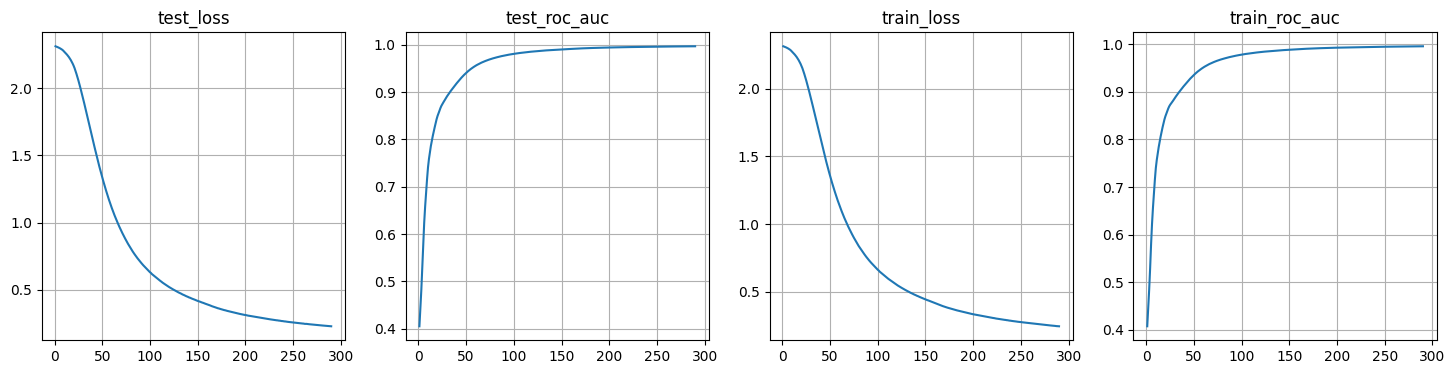

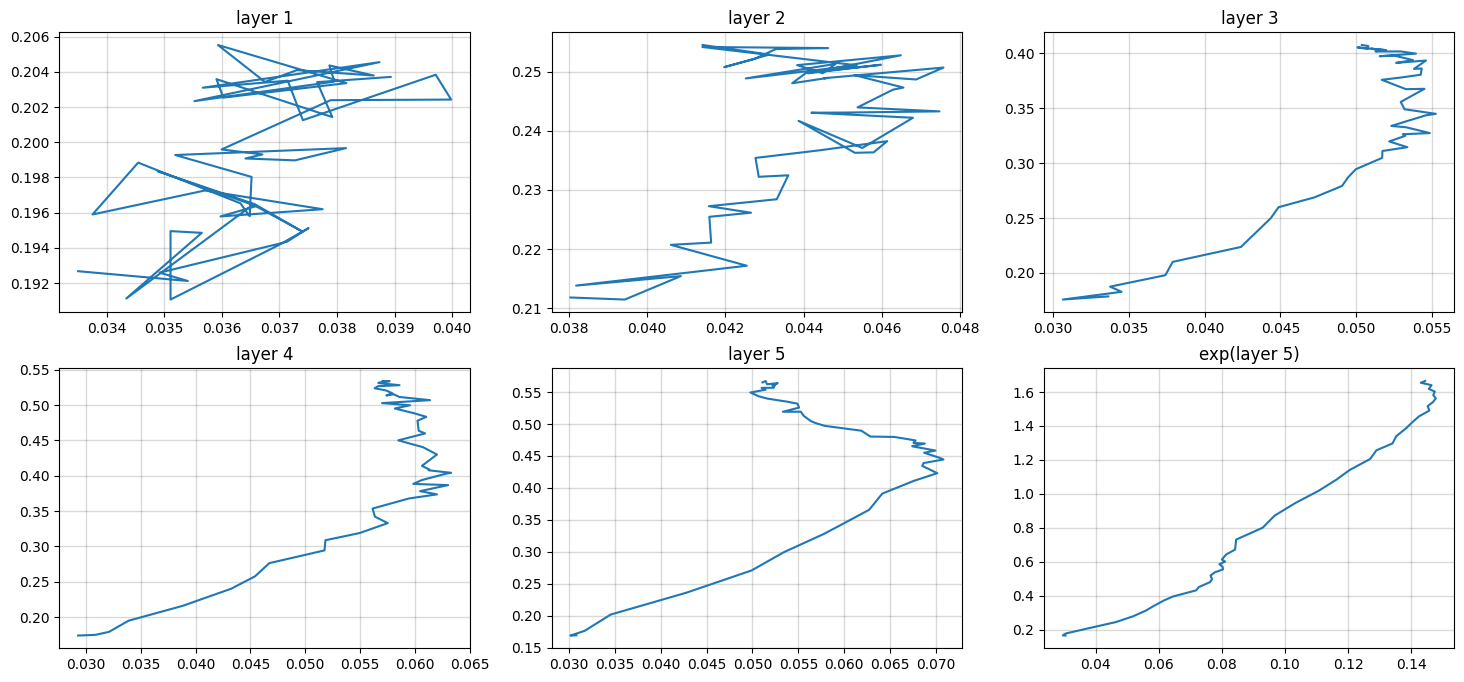

59it [00:05, 10.31it/s]
59it [00:05, 10.63it/s]
59it [00:05, 10.43it/s]
59it [00:05, 10.62it/s]
59it [00:05, 11.23it/s]
59it [00:05, 10.59it/s]
59it [00:05, 10.56it/s]
59it [00:05, 10.66it/s]
59it [00:05, 11.47it/s]
59it [00:05, 10.79it/s]


In [30]:
results = train_classifier(classifier, classifier_loss, classifier_opt,
                           train_dataloader, test_dataloader, eval_dataloader,
                           X_compressed, entropy_estimator_params,
                           compression='smi', n_epochs=classifier_n_epochs,
                           eval_epochs=eval_epochs,
                           filter_data=filter_data)

# results = train_classifier(classifier, classifier_loss, classifier_opt,
#                            train_dataloader, test_dataloader, eval_dataloader,
#                            X_compressed, entropy_estimator_params,
#                            compression, n_epochs=classifier_n_epochs,
#                            filter_data=None)

In [31]:
# results["filtered_MI_X_L"] = {layer_name: filter_data(values) for layer_name, values in results["MI_X_L"].items()}
# results["filtered_MI_L_Y"] = {layer_name: filter_data(values) for layer_name, values in results["MI_L_Y"].items()}

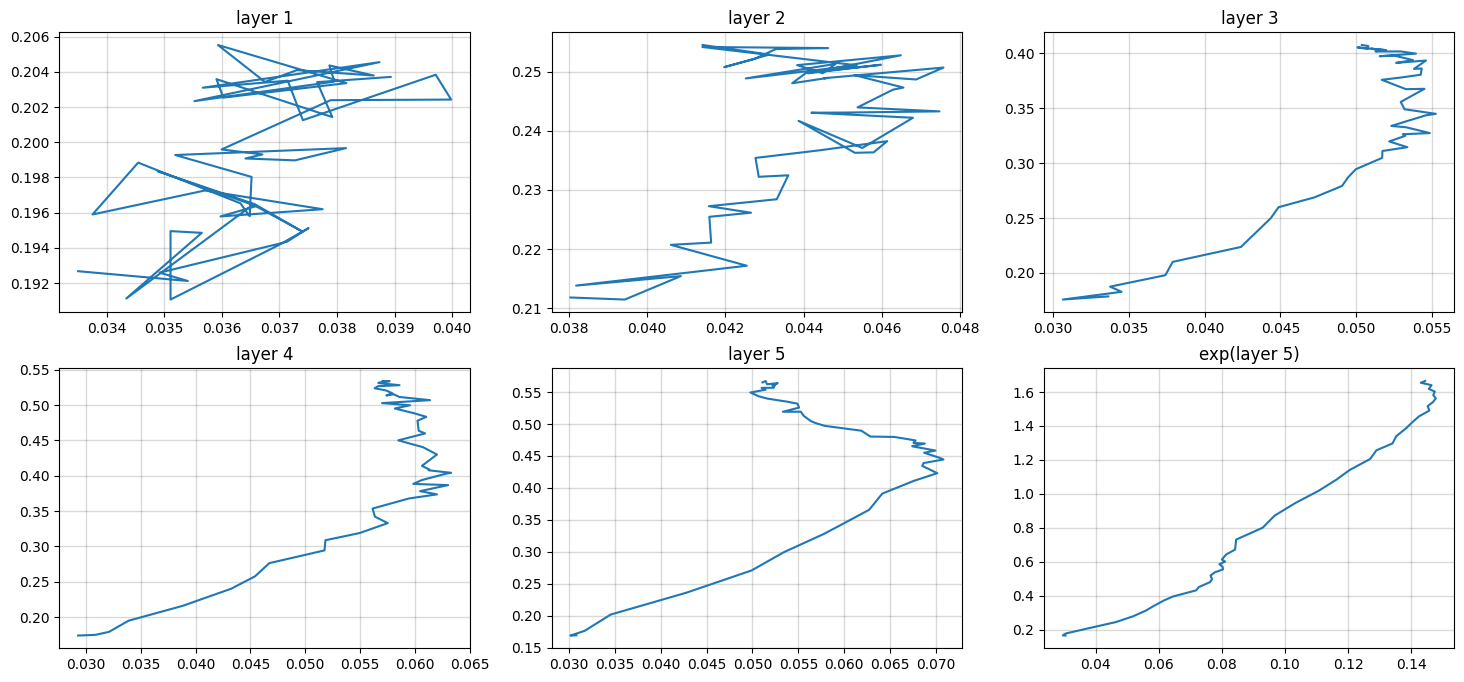

In [32]:
plot_MI_planes(results["MI_X_L"], results["MI_L_Y"], None, None)

In [33]:
# Saving all the results and settings.

settings = {
    # Autoencoder for inputs.
    "X_latent_dim": X_latent_dim,
    "X_autoencoder_n_epochs": X_autoencoder_n_epochs,
    "load_X_autoencoder": load_X_autoencoder,
    
    # Autoencoder for layers.
    "L_latent_dim": L_latent_dim,
    "L_autoencoder_n_epochs": L_autoencoder_n_epochs,
    
    # Classifier.
    "classifier_lr": classifier_lr,
    "classifier_n_epochs": classifier_n_epochs,
    "sigma": sigma,
    
    # Batch size.
    "batch_size_train": batch_size_train,
    "batch_size_test": batch_size_test,
    
    # Mutual information estimator.
    "entropy_estimator_params": entropy_estimator_params,
    "compression": compression,
}

In [34]:
results_path

WindowsPath('C:/Users/MQTyor/ai_pc/Reserch_ai/Information_Theory/SMI creation/Reproduction/MNIST experiments/Information-v3/data/mutual_information/MNIST/results_smi')

In [35]:
def save_results(results: dict, settings: dict, path: Path):
    """
    Save IP experiments results (parameters, metrics, IP data, ...).
    """
    
    directory_path = path / (datetime.now().strftime("%d-%b-%Y_%H%M%S") + "/")
    directory_path.mkdir(exist_ok=True, parents=True)
    
    # Metrics.
    metrics = pd.DataFrame()
    for metric_name, metric_values in results['metrics'].items():
        metrics[metric_name] = metric_values
    metrics.to_csv(directory_path / "metrics.csv", index=False)
        
    # Mutual information.
    for layer_name in results["MI_X_L"].keys():
        MI_dataframe = pd.DataFrame()
        
        MI_dataframe["I(X;L)"] = [value[0] for value in results["MI_X_L"][layer_name]]
        MI_dataframe["I(L;Y)"] = [value[0] for value in results["MI_L_Y"][layer_name]]
        
        MI_dataframe["std I(X;L)"] = [value[1] for value in results["MI_X_L"][layer_name]]
        MI_dataframe["std I(L;Y)"] = [value[1] for value in results["MI_L_Y"][layer_name]]
        
        MI_dataframe["filtered I(X;L)"] = results["filtered_MI_X_L"][layer_name]
        MI_dataframe["filtered I(L;Y)"] = results["filtered_MI_L_Y"][layer_name]
        
        MI_dataframe.to_csv(directory_path / f"{layer_name}.csv", index=False)
        
    # Settings.
    with open(directory_path / "settings.json", 'w') as outfile:
        json.dump(settings, outfile)

In [36]:
save_results(results, settings, results_path)